In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
from scipy.signal import medfilt
from scipy.ndimage.interpolation import shift
import speclite.filters
from scipy.ndimage import gaussian_filter
from IPython.display import display
import astropy.io.fits as fits
import astropy.units as u, astropy.constants as c
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu

%load_ext autoreload
%autoreload 2
%matplotlib inline
path='/Users/dimitrimawet/Desktop/Simuls/etc/'

SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# HISPEC

## Inputs

In [23]:
water_vapor = 3. #mm
airmass = 1.9
diam = 10. * u.m
area = 76. * u.m * u.m
delta_lb = 0.001 * u.micron
wave = np.arange(0.8,2.5,delta_lb.value) 
fwhm = ((wave * u.micron / diam) * u.radian).to(u.arcsec)
solidangle = fwhm**2 * 1.13 #corrected for Gaussian beam (factor 1.13)

# Sky

In [24]:
sky_trans_wv=np.array([1.,1.6,3.,5.])#water vapor 
sky_trans_airmass=np.array([1.,1.5,2.])#airmass

sky_trans_tmp=np.genfromtxt(path+'sky/mktrans_zm_'+str(water_vapor)+'_'+str(airmass)+'.dat', skip_header=0)
sky_trans_dummy=sky_trans_tmp[:,1]
sky_trans_wave = sky_trans_tmp[:,0] #* u.nm
sky_trans_interp = np.copy(wave)

sky_trans_interp = np.interp(wave,sky_trans_wave, sky_trans_dummy)

(1.33, 1.49)

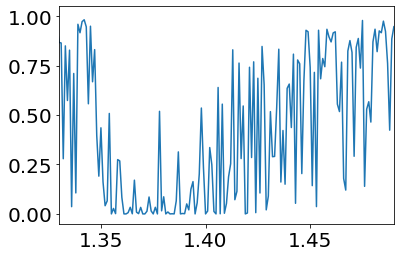

In [21]:
plt.plot(wave,sky_trans_interp )
plt.xlim([1.33,1.49])

(0.8, 0.99)

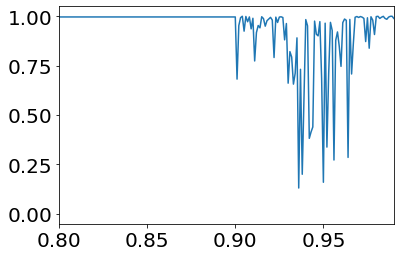

In [26]:
plt.plot(wave,sky_trans_interp )
plt.xlim([0.8,0.99])

In [22]:
index = np.where((wave > 1.33) & (wave < 1.49))
print('Sky',np.mean(sky_trans_interp[index]))

Sky 0.40749602500018245


## Telescope

In [4]:
oxydized_al_data = np.genfromtxt('oxydized_al.csv', delimiter=',', skip_header=1)
tel_m1_th = np.interp(wave,oxydized_al_data[:,0],oxydized_al_data[:,1])
tel_m2_th = tel_m1_th
tel_m3_th = tel_m1_th
tel_th = tel_m1_th * tel_m2_th * tel_m3_th
tel_em = (1-tel_th)

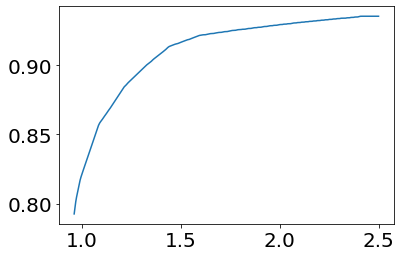

In [5]:
plt.plot(wave,tel_th)

## KAO accounting for dust extinction (to reproduce Nem's 2020 measurements)

In [6]:
oxydized_al_data = np.genfromtxt('oxydized_al.csv', delimiter=',', skip_header=1)
FSS99_ag_data = np.genfromtxt('FSS99_ag.csv', delimiter=',', skip_header=1)
opticoat_ag_data = np.genfromtxt('opticoat_ag.csv', delimiter=',', skip_header=1)
kao_shwfsdichroic_data = np.genfromtxt('kao_shwfsdichroic.csv', delimiter=',', skip_header=1)

In [7]:
dust_th = 0.97
K1_th = np.interp(wave,oxydized_al_data[:,0],oxydized_al_data[:,1]) * dust_th
K2_th = np.interp(wave,FSS99_ag_data[:,0],FSS99_ag_data[:,1]) * dust_th
K3_th = K1_th
TTM_th = np.interp(wave,opticoat_ag_data[:,0],opticoat_ag_data[:,1]) * dust_th
OAP1_th = TTM_th
DM_th = K2_th
OAP2_th = TTM_th
SHWFSDICH_th = np.interp(wave,kao_shwfsdichroic_data[:,0],kao_shwfsdichroic_data[:,1]) * dust_th
PICKOFF_th = TTM_th
KAO_th = K1_th * K2_th * K3_th * TTM_th * OAP1_th * DM_th * OAP2_th * SHWFSDICH_th * PICKOFF_th 
KAO_em = 1-KAO_th

(0.5, 0.7)

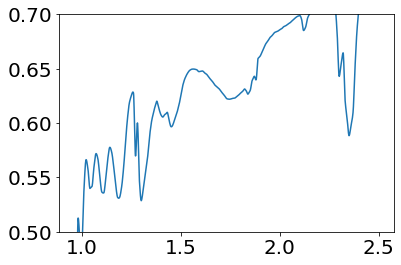

In [8]:
plt.plot(wave, KAO_th)
plt.ylim(0.5,0.7)

## HISPEC FEI

In [9]:
protected_au_data = np.genfromtxt('protected_au.csv', delimiter=',', skip_header=1) 

In [10]:
PWFSDICH_th = 0.94
FM1_th = np.interp(wave,protected_au_data[:,0],protected_au_data[:,1])
FOAP1_th = FM1_th
ADC_th = 0.9
TRACDICH_th = 0.94
redbluedich_th = 0.94
PIAA_th = 0.99**4
injectionlens_th = 0.955
HISPECFEI_th = PWFSDICH_th * FM1_th * FOAP1_th * ADC_th * TRACDICH_th * redbluedich_th * PIAA_th*injectionlens_th
HISPECFEI_em = 1.0 - HISPECFEI_th 

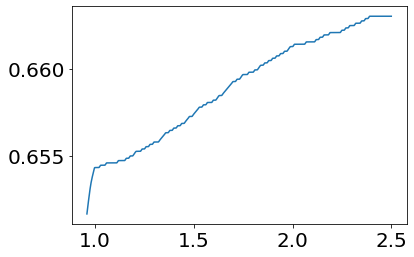

In [11]:
plt.plot(wave,HISPECFEI_th)

## Fiber losses

In [12]:
hispec_fiber_data = np.genfromtxt('hispec_yjhkfiber.csv', delimiter=',', skip_header=1)

In [13]:
fiberin_th = 0.99
fiberprop_th = np.interp(wave, hispec_fiber_data[:,0],hispec_fiber_data[:,1])
fiber_break = 0.98**3
fiberout_th = 0.99
fiber_th = fiberin_th * fiberprop_th * fiber_break * fiberout_th
fiber_em = 1.0 - fiber_th

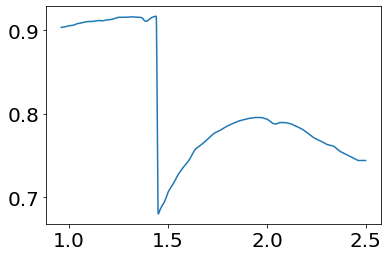

In [14]:
plt.plot(wave,fiber_th)

## HISPEC SPEC

In [15]:
protected_au_data = np.genfromtxt('protected_au.csv', delimiter=',', skip_header=1) 
echelle_data = np.genfromtxt('echelle.csv', delimiter=',', skip_header=1) 
cx_data = np.genfromtxt('cx.csv', delimiter=',', skip_header=1) 

In [41]:
TMA1_th = (np.interp(wave, protected_au_data[:,0],protected_au_data[:,1]))**3
cold_stop = 0.94
echelle_th = 0.7 * np.interp(wave,echelle_data[:,0],echelle_data[:,1])#80% max efficiency
cx_th = np.interp(wave,cx_data[:,0],cx_data[:,1])
FM1_th = np.interp(wave, protected_au_data[:,0],protected_au_data[:,1])
TMA2_th = TMA1_th
QE = 0.9
hispec_th = TMA1_th* cold_stop * echelle_th * cx_th *FM1_th * TMA2_th * QE
hispec_em=1.0-hispec_th

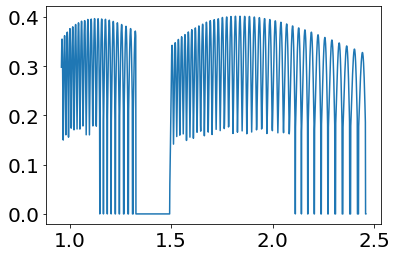

In [17]:
plt.plot(wave, hispec_th)

## Diffraction and partial correction coupling losses (no emissivity)

In [18]:
wfe_dyn = 0.120
wfe_ncpa = 0.02
wfe_tot = np.sqrt(wfe_dyn**2+wfe_ncpa**2)
strehl = np.exp(-(2*np.pi/wave * wfe_tot)**2)
diff_keck = 0.655
PIAA_boost = 1.3
coupling_efficiency = strehl * diff_keck * PIAA_boost

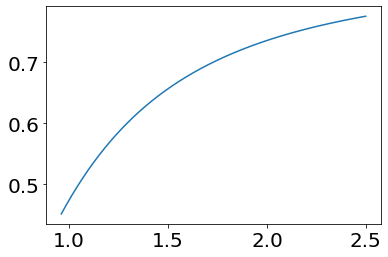

In [19]:
plt.plot(wave, coupling_efficiency)

## End-to-end Throughput

In [20]:
e2e_th = sky_trans_interp * tel_th * KAO_th * HISPECFEI_th * fiber_th * hispec_th * coupling_efficiency

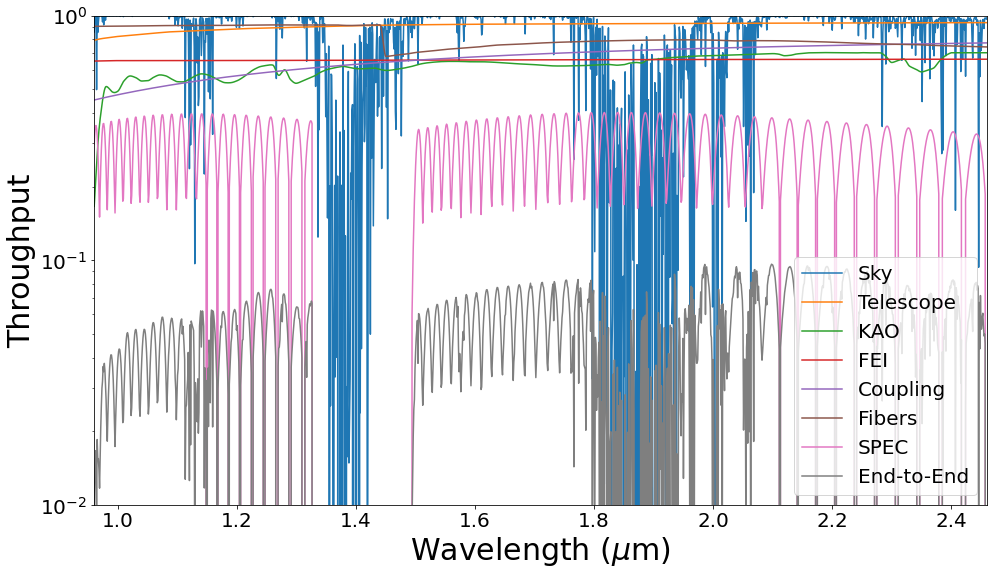

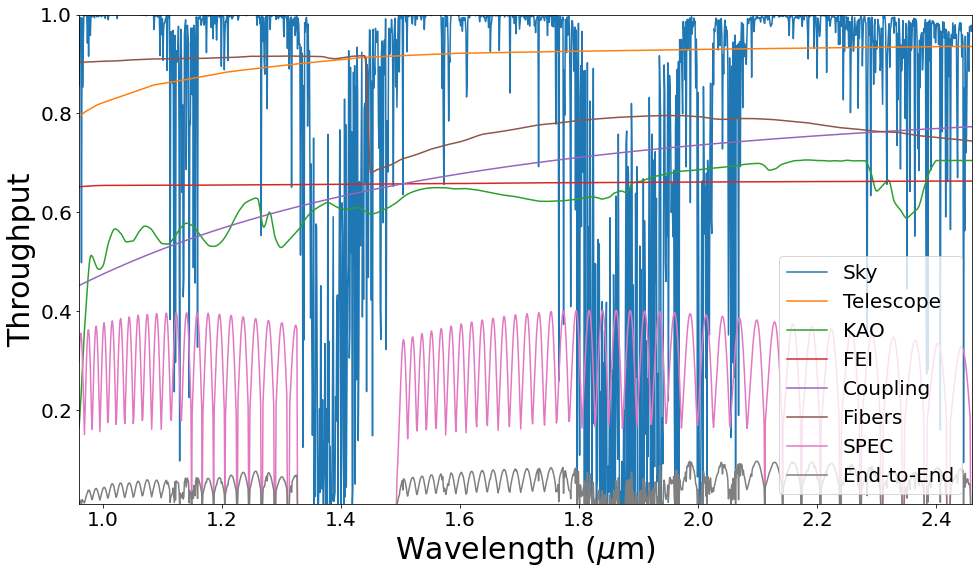

In [21]:
plt.figure(figsize=(16,9))
plt.plot(wave,sky_trans_interp, label='Sky')
plt.plot(wave,tel_th, label='Telescope')
plt.plot(wave,KAO_th, label='KAO')
plt.plot(wave,HISPECFEI_th, label='FEI')
plt.plot(wave,coupling_efficiency, label='Coupling')
plt.plot(wave,fiber_th, label='Fibers')
plt.plot(wave,hispec_th, label='SPEC')
plt.plot(wave,e2e_th, label='End-to-End')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Throughput')
plt.yscale('log')
plt.xlim(0.96,2.46)
plt.ylim(0.01,1)
plt.legend()
plt.savefig('HISPEC_throughput_log.png')

plt.figure(figsize=(16,9))
plt.plot(wave,sky_trans_interp, label='Sky')
plt.plot(wave,tel_th, label='Telescope')
plt.plot(wave,KAO_th, label='KAO')
plt.plot(wave,HISPECFEI_th, label='FEI')
plt.plot(wave,coupling_efficiency, label='Coupling')
plt.plot(wave,fiber_th, label='Fibers')
plt.plot(wave,hispec_th, label='SPEC')
plt.plot(wave,e2e_th, label='End-to-End')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Throughput')
plt.xlim(0.96,2.46)
plt.ylim(0.01,1)
plt.legend()
plt.savefig('HISPEC_throughput_lin.png')

In [22]:
index = np.where((wave > 0.98) & (wave < 1.1))
print('Sky',np.mean(sky_trans_interp[index]))
print('Telescope',np.mean(tel_th[index]))
print('KAO',np.mean(KAO_th[index]))
print('FEI (PIAA)',np.mean(HISPECFEI_th[index]))
print('FIB',np.mean(fiber_th[index]))
print('Coupling efficiency',np.mean(coupling_efficiency[index]))
print('SPEC',np.mean(hispec_th[index]))
print('E2E',np.max(e2e_th[index]))

Sky 0.9976745378151268
Telescope 0.838083821328744
KAO 0.541700050938314
FEI (PIAA) 0.6543761506451395
FIB 0.9075786246374833
Coupling efficiency 0.49554959632390816
SPEC 0.2958400633535761
E2E 0.058468835813095664


In [23]:
index = np.where((wave > 1.1) & (wave < 1.4))
print('Sky',np.mean(sky_trans_interp[index]))
print('Telescope',np.mean(tel_th[index]))
print('KAO',np.mean(KAO_th[index]))
print('FEI (PIAA)',np.mean(HISPECFEI_th[index]))
print('FIB',np.mean(fiber_th[index]))
print('Coupling efficiency',np.mean(coupling_efficiency[index]))
print('SPEC',np.mean(hispec_th[index]))
print('E2E',np.max(e2e_th[index]))

Sky 0.8113144581939924
Telescope 0.8878077453931946
KAO 0.5749848353695327
FEI (PIAA) 0.6554525792737643
FIB 0.913569340301761
Coupling efficiency 0.5834853299425938
SPEC 0.21855203149270147
E2E 0.07601339928080812


In [24]:
index = np.where((wave > 1.48) & (wave < 1.8))
print('Sky',np.mean(sky_trans_interp[index]))
print('Telescope',np.mean(tel_th[index]))
print('KAO',np.mean(KAO_th[index]))
print('FEI (PIAA)',np.mean(HISPECFEI_th[index]))
print('FIB',np.mean(fiber_th[index]))
print('Coupling efficiency',np.mean(coupling_efficiency[index]))
print('SPEC',np.mean(hispec_th[index]))
print('E2E',np.max(e2e_th[index]))

Sky 0.9674766624999733
Telescope 0.9218832659355615
KAO 0.6352161943555068
FEI (PIAA) 0.6586077317487342
FIB 0.7506957000668444
Coupling efficiency 0.6839248838731631
SPEC 0.27994879103584935
E2E 0.08333590390159969


In [25]:
index = np.where((wave > 2.0) & (wave < 2.46))
print('Sky',np.mean(sky_trans_interp[index]))
print('Telescope',np.mean(tel_th[index]))
print('KAO',np.mean(KAO_th[index]))
print('FEI (PIAA)',np.mean(HISPECFEI_th[index]))
print('FIB',np.mean(fiber_th[index]))
print('Coupling efficiency',np.mean(coupling_efficiency[index]))
print('SPEC',np.mean(hispec_th[index]))
print('E2E',np.max(e2e_th[index]))

Sky 0.9053509934783014
Telescope 0.932709605965408
KAO 0.6842754152816225
FEI (PIAA) 0.6622024573180686
FIB 0.7721208123534669
Coupling efficiency 0.7561884127160607
SPEC 0.26934713081089956
E2E 0.09628660805465374


## Thermal background

## Sky

In [26]:
sky_background_MK = np.zeros([4,3,235000])
sky_background_MK_wv = np.array([1.,1.6,3.,5.])#water vapor 
sky_background_MK_airmass = np.array([1.,1.5,2.])#airmass
sky_background_MK_tmp = np.genfromtxt(path+'sky/mk_skybg_zm_'+str(water_vapor)+'_'+str(airmass)+'_ph.dat', skip_header=0)
sky_background_MK = sky_background_MK_tmp[:,1]
sky_background_MK_wave = sky_background_MK_tmp[:,0] #* u.nm
sky_background_interp=np.interp(wave * 1e+3, sky_background_MK_wave, sky_background_MK) * u.photon/(u.s*u.arcsec**2*u.nm*u.m**2) * area * solidangle * 2000/100000/3 * u.nm 

## Telescope

In [28]:
T_tel = 276
tel_bb = (blackbody_lambda(wave * u.micron, T_tel).to(u.erg/(u.micron * u.s * u.cm**2 * u.arcsec**2)) * area.to(u.cm**2) * solidangle)
tel_thermal = tel_em * tel_bb.to(u.photon/u.s/u.micron, equivalencies=u.spectral_density(wave * u.micron)) * 2./100000/3 * u.micron


In [29]:
tel_thermal.unit

Unit("ph / s")

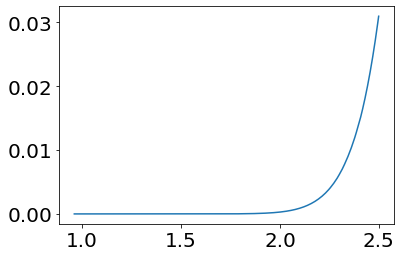

In [30]:
plt.plot(wave,tel_thermal)

## KAO

In [33]:
T_KAO = 276

KAO_bb = (blackbody_lambda(wave * u.micron, T_KAO).to(u.erg/(u.micron * u.s * u.cm**2 * u.arcsec**2)) * area.to(u.cm**2) * solidangle)
KAO_thermal = KAO_em * KAO_bb.to(u.photon/u.s/u.micron, equivalencies=u.spectral_density(wave * u.micron)) * 2./100000/3 * u.micron


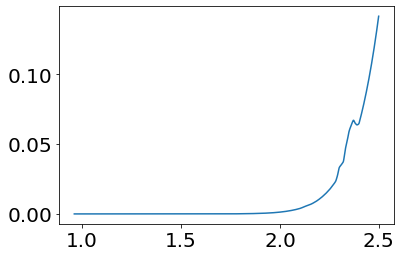

In [35]:
plt.plot(wave,KAO_thermal)

## FEI

In [36]:
T_HISPECFEI = 276
HISPECFEI_bb = (blackbody_lambda(wave * u.micron, T_HISPECFEI).to(u.erg/(u.micron * u.s * u.cm**2 * u.arcsec**2)) * area.to(u.cm**2) * solidangle)
HISPECFEI_thermal = HISPECFEI_em * HISPECFEI_bb.to(u.photon/u.s/u.micron, equivalencies=u.spectral_density(wave* u.micron)) * 2./100000/3 * u.micron


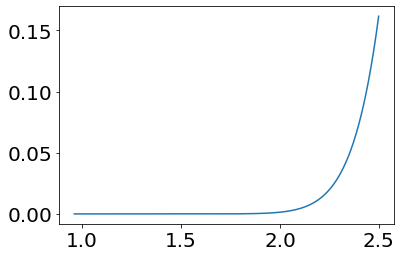

In [37]:
plt.plot(wave,HISPECFEI_thermal)

## Fibers

In [38]:
T_fiber = 276
fiber_bb = (blackbody_lambda(wave* u.micron, T_fiber).to(u.erg/(u.micron * u.s * u.cm**2 * u.arcsec**2)) * area.to(u.cm**2) * solidangle)
fiber_thermal = fiber_em * fiber_bb.to(u.photon/u.s/u.micron, equivalencies=u.spectral_density(wave* u.micron)) * 2./100000/3 * u.micron

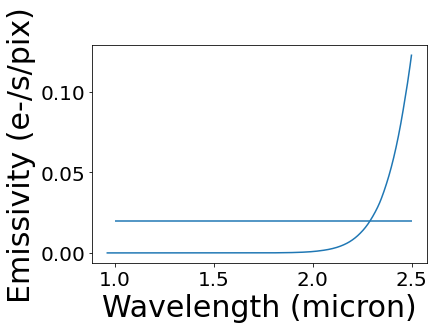

In [39]:
plt.plot(wave, fiber_thermal)
plt.xlabel('Wavelength (micron)')
plt.ylabel('Emissivity (e-/s/pix)')
plt.hlines(0.02,1,2.5)

## Spectrograph

In [42]:
T_spectro = 77
hispec_bb = (blackbody_lambda(wave* u.micron, T_spectro).to(u.erg/(u.micron * u.s * u.cm**2 * u.arcsec**2)) * area.to(u.cm**2) * solidangle)
hispec_thermal = hispec_em * hispec_bb.to(u.photon/u.s/u.micron, equivalencies=u.spectral_density(wave* u.micron)) * 2./100000/3 * u.micron

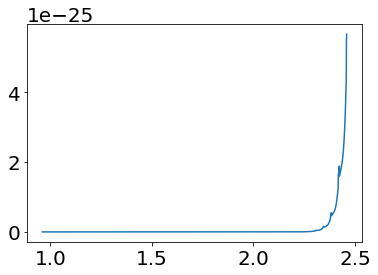

In [43]:
plt.plot(wave, hispec_thermal)

## Dark current

In [44]:
dc = 0.02#e- per pix per second
R=100000
samp = 3
delta_lb_pix = 2./100000/samp**2
npix = delta_lb.value / delta_lb_pix
print(npix*dc)

8.999999999999998


# E2E thermal

In [46]:
e2e_thermal = sky_background_interp + tel_thermal + KAO_thermal + HISPECFEI_thermal + fiber_thermal + hispec_thermal

(0.0, 0.5)

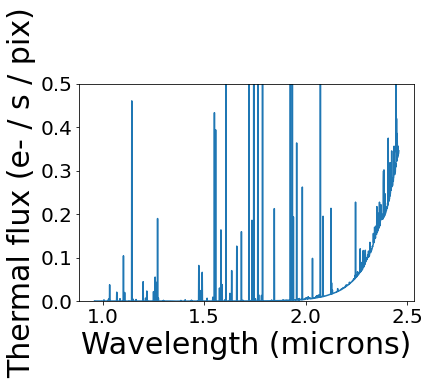

In [48]:
plt.plot(wave, e2e_thermal)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Thermal flux (e- / s / pix)')
plt.ylim([0,0.5])

In [ ]:
plt.plot(wave, e2e_thermal)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Thermal flux (e- / s / pix)')
plt.ylim([0,0.1])

In [ ]:
import numpy as np
np.exp(-(np.sqrt(-np.log(0.38))*1.6/2.2)**2)